In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install hdbscan
#!pip install catboost

In [ ]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
from sklearn.metrics import make_scorer

# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
#from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import pandas as pd
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
import hdbscan
import os
import warnings
warnings.filterwarnings("ignore")


#Set seed
import random
random.seed(1)
np.random.seed(1)

SEED=1
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgbm
import re

# 0-59 train, test set 생성

## train set 생성

In [ ]:
import gc
gc.collect()

662

In [ ]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/Dacon_수력원자력/')

In [ ]:
data = pd.DataFrame({})

for i in range(0, 30):
    index = np.arange(0,30) + 30*i
    df = pd.DataFrame({})
    for k in index:
        if k == 828:
            stop = True
            break
        else:
            stop = False
            try:
              temp = pd.read_csv("train/" + str(k) + ".csv")
              df = df.append(temp[0:60])
              del temp
              gc.collect()
            except:
              pass
            
            print(k)
    
    data = data.append(df)
    if stop:
        break
    

In [ ]:
data_index = []
for j in range(0,827):
    data_index.extend([j]*60)
    
data['id'] = data_index

In [ ]:
train_label = pd.read_csv("train_label.csv")

In [ ]:
data = pd.merge(data, train_label, on = 'id')

In [ ]:
#train = data.copy()
train.to_csv("/content/drive/MyDrive/Dacon_수력원자력/train_0_59.csv")

## test set 생성

In [ ]:
data = pd.DataFrame({})

for i in range(0, 30):
    index = np.arange(0,30) + 30*i
    df = pd.DataFrame({})
    for k in index:
        k = k + 828
        if k == 1548:
            stop = True
            break
        else:
            stop = False
            try:
              temp = pd.read_csv("test/" + str(k) + ".csv")
              df = df.append(temp[0:60])
              del temp
              gc.collect()
            except:
              pass
            
    
    data = data.append(df)
    if stop:
        break

In [ ]:
data_index = []
for j in range(828,1546):
    data_index.extend([j]*60)
    
data['id'] = data_index

test = data.copy(); del data
test['label'] = -1
test.to_csv("/content/drive/MyDrive/Dacon_수력원자력/test_0_59.csv")

In [ ]:
test.to_csv("/content/drive/MyDrive/Dacon_수력원자력/test_0_59.csv")

# 전처리

## 해당 문자열은 0으로

In [ ]:
#train = pd.read_csv("train_1min.csv")
#test = pd.read_csv("test_1min.csv")

train = train.sort_values(['label','id','time'], axis=0)
test = test.sort_values(['id','time'], axis=0)

df = train.append(test) ;df.to_csv("/content/drive/MyDrive/Dacon_수력원자력/df_0_59.csv")

In [ ]:
df.index = [i for i in range(0, len(df))]

In [ ]:
del train
del test

In [ ]:
drop = ['Bad', 'CLOSE', 'Equip Fail', 'No Data', 'Normal', 'OFF', 'ON', 'OPEN', 'System.Char[]','MID POSITION', 'Configure']

In [ ]:
check = []
for i in df.columns:
    if any([j in df[i].unique() for j in drop]) == True:
        check.append(i)
index_drop = []
for i in check:
    index = [j in drop for j in df[i]]
    index_drop.extend(df.loc[index, i].index)

In [ ]:
for i in index_drop:
    for j in check:
        if df.loc[i,j] in drop:
            df.loc[i,j] = 0

## 실수 처리

In [ ]:
for i in df.columns:
    df[i] = df[i].astype(float)
    print(i)

## 모두 값이 똑같은 열은 제거

In [ ]:
from tqdm import tqdm
def delete_same_col(df):
    column_drop = []
    column_check = []
    for i in tqdm(df.columns):
        if len(set([float(i) for i in df[i]])) == 1:
            column_drop.append(i)
        else:
            column_check.append(i)
    return(df.drop(column_drop, axis=1))

In [ ]:
index = [index for index, value in enumerate(df['time']) if value in np.arange(9,60)]
df_0 = df.iloc[index,:].copy()

In [ ]:
df_1 = delete_same_col(df)
#df_0 = delete_same_col(df_0)
#del df

In [ ]:
feature = df_1.columns[10:30]

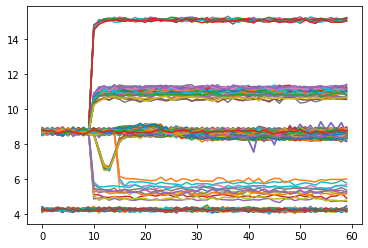

In [ ]:
for id in df['id'].unique():
  temp = df[df['id'] == id]
  plt.plot(np.array(temp['V0001']))

# 시각 1 

In [ ]:
def df_reduction(df_0):
    #feature = df_0.columns[1:3915]

    df_reduc = df_0.loc[:,['time','V0001','id','label']].copy()
    df_reduc = df_reduc.set_index(['label','id','time']).unstack()
    df_reduc.columns = df_reduc.columns.map(lambda x: '{}_{}'.format(x[0], x[1]))
    df_reduc = df_reduc.reset_index()
    df_reduc = df_reduc.loc[:,['id','label']]
    df_reduc = df_reduc.sort_values(['id'])

    for j in feature:
    #unstack
        example = df_0.loc[:,['time',j,'id','label']].copy()
        example = example.set_index(['label','id','time']).unstack()
        example.columns = example.columns.map(lambda x: '{}_{}'.format(x[0], x[1]))
        example = example.reset_index()
    
    #Scaling
        Min = example.iloc[:,2:].min().min()
        Max = example.iloc[:,2:].max().max()
        example.iloc[:,2:] = example.iloc[:,2:].transform(lambda x: (x-Min)/(Max-Min))
    
    #Sort
        example = example.sort_values(['id'])
    
    #split train test
    #train = example[example['label'] != -1]
    #test = example[example['label'] == -1]
        
    
    #Clustering
        try:
            np.random.seed(1)
            random.seed(1)
            clusterer = hdbscan.HDBSCAN(min_cluster_size=2,
                                    gen_min_span_tree=True, allow_single_cluster=True,
                                    cluster_selection_epsilon=0.0001)
            clusterer.fit(example.iloc[:,2:])
        
        #df_reduc_train[j] = clusterer.labels_
            df_reduc[j] = clusterer.labels_ 
            
        #test_labels, strength = hdbscan.approximate_predict(clusterer, test.iloc[:,2:])
        #df_reduc_test[j] = test_labels
        
            print(j)
        #success.append(j)
        except:
            pass

    
    #똑같은 변수 제거
    #cor = df_reduc.iloc[:,2:].corr()
    #for i in range(0,len(cor)):
    #    cor.iloc[i,i] = 0
    
    #drop = []
    #for i in range(0, len(cor)):
    #    value = abs(cor.iloc[i,i:])
    #    drop.extend(value.index[value == 1]) 

    #df_reduc.drop(drop, axis=1, inplace=True)
    #df_reduc.index = [i for i in range(0, len(df_reduc))]    
          
    return df_reduc

In [ ]:
df_reduc = df_reduction(df_1)

V0009
V0010
V0011
V0012
V0013
V0014
V0015
V0016
V0017
V0018
V0028
V0029
V0030
V0031
V0032
V0033


In [ ]:
df_reduc

,id,label,V0009,V0010,V0011,V0012,V0013,V0014,V0015,V0016,V0017,V0018,V0028,V0029,V0030,V0031,V0032,V0033
1091,0.0,110.0,6,11,5,13,1,1,1,1,7,8,8,8,9,8,8,8
855,1.0,29.0,6,11,5,13,1,1,1,1,7,8,8,8,9,8,8,8
1114,2.0,111.0,6,11,5,13,1,1,1,1,7,8,8,8,9,8,8,8
1474,3.0,176.0,6,11,5,13,1,1,1,1,7,8,8,8,9,8,8,8
1328,4.0,130.0,6,11,5,13,1,1,1,1,7,8,8,8,9,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,1541.0,-1.0,6,11,5,13,1,1,1,1,7,8,8,8,9,8,8,8
714,1542.0,-1.0,6,11,5,13,1,1,1,1,7,8,8,8,9,8,8,8
715,1543.0,-1.0,6,11,5,13,1,1,1,1,7,8,8,8,9,8,8,8
716,1544.0,-1.0,6,11,5,13,1,1,1,1,7,8,8,8,9,8,8,8


In [ ]:
df_reduc.to_csv("/content/drive/MyDrive/Dacon_수력원자력/df_reduc.csv")

# 모델링1

In [ ]:
train = df_reduc[df_reduc['label'] != -1].copy()
test = df_reduc[df_reduc['label'] == -1].copy()

In [ ]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
X_train = train.iloc[:,2:]
y_train = train['label']
X_test = test.iloc[:,2:]

train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_train, label=y_train)

In [ ]:
model = CatBoostClassifier(loss_function= 'MultiClass',iterations=1500,learning_rate=0.15, random_state=1)
model.fit(train_pool,plot=True,eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5.0365026	test: 5.0365026	best: 5.0365026 (0)	total: 2.62s	remaining: 1h 5m 31s
1:	learn: 4.8452503	test: 4.8452503	best: 4.8452503 (1)	total: 5.14s	remaining: 1h 4m 13s
2:	learn: 4.6067937	test: 4.6067937	best: 4.6067937 (2)	total: 7.76s	remaining: 1h 4m 32s
3:	learn: 4.3888030	test: 4.3888030	best: 4.3888030 (3)	total: 10.3s	remaining: 1h 4m 24s
4:	learn: 4.2707972	test: 4.2707972	best: 4.2707972 (4)	total: 12.9s	remaining: 1h 4m 5s
5:	learn: 4.1825890	test: 4.1825890	best: 4.1825890 (5)	total: 15.5s	remaining: 1h 4m 14s
6:	learn: 4.0855048	test: 4.0855048	best: 4.0855048 (6)	total: 18s	remaining: 1h 4m 9s
7:	learn: 3.9892960	test: 3.9892960	best: 3.9892960 (7)	total: 20.7s	remaining: 1h 4m 22s
8:	learn: 3.9207588	test: 3.9207588	best: 3.9207588 (8)	total: 23.3s	remaining: 1h 4m 19s
9:	learn: 3.8566919	test: 3.8566919	best: 3.8566919 (9)	total: 26s	remaining: 1h 4m 34s
10:	learn: 3.8117693	test: 3.8117693	best: 3.8117693 (10)	total: 28.7s	remaining: 1h 4m 41s
11:	learn: 3.7

90:	learn: 1.8566854	test: 1.8566854	best: 1.8566854 (90)	total: 4m 2s	remaining: 1h 2m 37s
91:	learn: 1.8501811	test: 1.8501811	best: 1.8501811 (91)	total: 4m 5s	remaining: 1h 2m 35s
92:	learn: 1.8451696	test: 1.8451696	best: 1.8451696 (92)	total: 4m 8s	remaining: 1h 2m 33s
93:	learn: 1.8234816	test: 1.8234816	best: 1.8234816 (93)	total: 4m 10s	remaining: 1h 2m 30s
94:	learn: 1.8166811	test: 1.8166811	best: 1.8166811 (94)	total: 4m 13s	remaining: 1h 2m 27s
95:	learn: 1.7851349	test: 1.7851349	best: 1.7851349 (95)	total: 4m 15s	remaining: 1h 2m 23s
96:	learn: 1.7706117	test: 1.7706117	best: 1.7706117 (96)	total: 4m 18s	remaining: 1h 2m 21s
97:	learn: 1.7633521	test: 1.7633521	best: 1.7633521 (97)	total: 4m 21s	remaining: 1h 2m 18s
98:	learn: 1.7581052	test: 1.7581052	best: 1.7581052 (98)	total: 4m 24s	remaining: 1h 2m 16s
99:	learn: 1.7511175	test: 1.7511175	best: 1.7511175 (99)	total: 4m 26s	remaining: 1h 2m 13s
100:	learn: 1.7293444	test: 1.7293444	best: 1.7293444 (100)	total: 4m 29s

178:	learn: 1.2369622	test: 1.2369622	best: 1.2369622 (178)	total: 8m 3s	remaining: 59m 24s
179:	learn: 1.2294933	test: 1.2294933	best: 1.2294933 (179)	total: 8m 5s	remaining: 59m 21s
180:	learn: 1.2283260	test: 1.2283260	best: 1.2283260 (180)	total: 8m 8s	remaining: 59m 17s
181:	learn: 1.2260752	test: 1.2260752	best: 1.2260752 (181)	total: 8m 10s	remaining: 59m 14s
182:	learn: 1.2249733	test: 1.2249733	best: 1.2249733 (182)	total: 8m 13s	remaining: 59m 11s
183:	learn: 1.2224384	test: 1.2224384	best: 1.2224384 (183)	total: 8m 16s	remaining: 59m 7s
184:	learn: 1.2170467	test: 1.2170467	best: 1.2170467 (184)	total: 8m 18s	remaining: 59m 4s
185:	learn: 1.2093518	test: 1.2093518	best: 1.2093518 (185)	total: 8m 21s	remaining: 59m 1s
186:	learn: 1.1994059	test: 1.1994059	best: 1.1994059 (186)	total: 8m 23s	remaining: 58m 57s
187:	learn: 1.1983901	test: 1.1983901	best: 1.1983901 (187)	total: 8m 26s	remaining: 58m 54s
188:	learn: 1.1790576	test: 1.1790576	best: 1.1790576 (188)	total: 8m 29s	re

267:	learn: 0.8765832	test: 0.8765832	best: 0.8765832 (267)	total: 11m 55s	remaining: 54m 51s
268:	learn: 0.8704549	test: 0.8704549	best: 0.8704549 (268)	total: 11m 58s	remaining: 54m 48s
269:	learn: 0.8696735	test: 0.8696735	best: 0.8696735 (269)	total: 12m 1s	remaining: 54m 45s
270:	learn: 0.8686074	test: 0.8686074	best: 0.8686074 (270)	total: 12m 3s	remaining: 54m 43s
271:	learn: 0.8634131	test: 0.8634131	best: 0.8634131 (271)	total: 12m 6s	remaining: 54m 40s
272:	learn: 0.8597517	test: 0.8597517	best: 0.8597517 (272)	total: 12m 9s	remaining: 54m 37s
273:	learn: 0.8591073	test: 0.8591073	best: 0.8591073 (273)	total: 12m 11s	remaining: 54m 34s
274:	learn: 0.8548345	test: 0.8548345	best: 0.8548345 (274)	total: 12m 14s	remaining: 54m 32s
275:	learn: 0.8526463	test: 0.8526463	best: 0.8526463 (275)	total: 12m 17s	remaining: 54m 29s
276:	learn: 0.8451030	test: 0.8451030	best: 0.8451030 (276)	total: 12m 20s	remaining: 54m 28s
277:	learn: 0.8401962	test: 0.8401962	best: 0.8401962 (277)	tota

355:	learn: 0.6389715	test: 0.6389715	best: 0.6389715 (355)	total: 16m	remaining: 51m 26s
356:	learn: 0.6371166	test: 0.6371166	best: 0.6371166 (356)	total: 16m 3s	remaining: 51m 24s
357:	learn: 0.6361577	test: 0.6361577	best: 0.6361577 (357)	total: 16m 5s	remaining: 51m 21s
358:	learn: 0.6335412	test: 0.6335412	best: 0.6335412 (358)	total: 16m 8s	remaining: 51m 18s
359:	learn: 0.6305174	test: 0.6305174	best: 0.6305174 (359)	total: 16m 11s	remaining: 51m 15s
360:	learn: 0.6272072	test: 0.6272072	best: 0.6272072 (360)	total: 16m 14s	remaining: 51m 13s
361:	learn: 0.6223262	test: 0.6223262	best: 0.6223262 (361)	total: 16m 16s	remaining: 51m 10s
362:	learn: 0.6195936	test: 0.6195936	best: 0.6195936 (362)	total: 16m 19s	remaining: 51m 7s
363:	learn: 0.6170457	test: 0.6170457	best: 0.6170457 (363)	total: 16m 22s	remaining: 51m 5s
364:	learn: 0.6142809	test: 0.6142809	best: 0.6142809 (364)	total: 16m 24s	remaining: 51m 2s
365:	learn: 0.6124162	test: 0.6124162	best: 0.6124162 (365)	total: 16m

443:	learn: 0.4563147	test: 0.4563147	best: 0.4563147 (443)	total: 20m 7s	remaining: 47m 50s
444:	learn: 0.4545492	test: 0.4545492	best: 0.4545492 (444)	total: 20m 9s	remaining: 47m 48s
445:	learn: 0.4533320	test: 0.4533320	best: 0.4533320 (445)	total: 20m 12s	remaining: 47m 45s
446:	learn: 0.4510217	test: 0.4510217	best: 0.4510217 (446)	total: 20m 15s	remaining: 47m 43s
447:	learn: 0.4483211	test: 0.4483211	best: 0.4483211 (447)	total: 20m 18s	remaining: 47m 40s
448:	learn: 0.4479957	test: 0.4479957	best: 0.4479957 (448)	total: 20m 20s	remaining: 47m 37s
449:	learn: 0.4453807	test: 0.4453807	best: 0.4453807 (449)	total: 20m 23s	remaining: 47m 34s
450:	learn: 0.4434843	test: 0.4434843	best: 0.4434843 (450)	total: 20m 26s	remaining: 47m 32s
451:	learn: 0.4422149	test: 0.4422149	best: 0.4422149 (451)	total: 20m 29s	remaining: 47m 29s
452:	learn: 0.4404692	test: 0.4404692	best: 0.4404692 (452)	total: 20m 31s	remaining: 47m 27s
453:	learn: 0.4386300	test: 0.4386300	best: 0.4386300 (453)	to

531:	learn: 0.3213622	test: 0.3213622	best: 0.3213622 (531)	total: 24m 8s	remaining: 43m 55s
532:	learn: 0.3196595	test: 0.3196595	best: 0.3196595 (532)	total: 24m 11s	remaining: 43m 53s
533:	learn: 0.3191341	test: 0.3191341	best: 0.3191341 (533)	total: 24m 14s	remaining: 43m 51s
534:	learn: 0.3171748	test: 0.3171748	best: 0.3171748 (534)	total: 24m 17s	remaining: 43m 49s
535:	learn: 0.3169361	test: 0.3169361	best: 0.3169361 (535)	total: 24m 20s	remaining: 43m 46s
536:	learn: 0.3150995	test: 0.3150995	best: 0.3150995 (536)	total: 24m 23s	remaining: 43m 44s
537:	learn: 0.3140166	test: 0.3140166	best: 0.3140166 (537)	total: 24m 26s	remaining: 43m 41s
538:	learn: 0.3124357	test: 0.3124357	best: 0.3124357 (538)	total: 24m 28s	remaining: 43m 38s
539:	learn: 0.3121747	test: 0.3121747	best: 0.3121747 (539)	total: 24m 31s	remaining: 43m 36s
540:	learn: 0.3110985	test: 0.3110985	best: 0.3110985 (540)	total: 24m 34s	remaining: 43m 33s
541:	learn: 0.3097967	test: 0.3097967	best: 0.3097967 (541)	t

619:	learn: 0.2404886	test: 0.2404886	best: 0.2404886 (619)	total: 28m 6s	remaining: 39m 54s
620:	learn: 0.2397821	test: 0.2397821	best: 0.2397821 (620)	total: 28m 9s	remaining: 39m 51s
621:	learn: 0.2396488	test: 0.2396488	best: 0.2396488 (621)	total: 28m 12s	remaining: 39m 48s
622:	learn: 0.2386347	test: 0.2386347	best: 0.2386347 (622)	total: 28m 14s	remaining: 39m 45s
623:	learn: 0.2377596	test: 0.2377596	best: 0.2377596 (623)	total: 28m 17s	remaining: 39m 43s
624:	learn: 0.2365906	test: 0.2365906	best: 0.2365906 (624)	total: 28m 20s	remaining: 39m 40s
625:	learn: 0.2354061	test: 0.2354061	best: 0.2354061 (625)	total: 28m 23s	remaining: 39m 37s
626:	learn: 0.2352227	test: 0.2352227	best: 0.2352227 (626)	total: 28m 25s	remaining: 39m 35s
627:	learn: 0.2348121	test: 0.2348121	best: 0.2348121 (627)	total: 28m 28s	remaining: 39m 32s
628:	learn: 0.2342898	test: 0.2342898	best: 0.2342898 (628)	total: 28m 31s	remaining: 39m 30s
629:	learn: 0.2335133	test: 0.2335133	best: 0.2335133 (629)	to

707:	learn: 0.1871450	test: 0.1871450	best: 0.1871450 (707)	total: 32m 13s	remaining: 36m 2s
708:	learn: 0.1867272	test: 0.1867272	best: 0.1867272 (708)	total: 32m 16s	remaining: 35m 59s
709:	learn: 0.1861093	test: 0.1861093	best: 0.1861093 (709)	total: 32m 18s	remaining: 35m 57s
710:	learn: 0.1858805	test: 0.1858805	best: 0.1858805 (710)	total: 32m 21s	remaining: 35m 54s
711:	learn: 0.1849114	test: 0.1849114	best: 0.1849114 (711)	total: 32m 24s	remaining: 35m 52s
712:	learn: 0.1842168	test: 0.1842168	best: 0.1842168 (712)	total: 32m 27s	remaining: 35m 49s
713:	learn: 0.1837048	test: 0.1837048	best: 0.1837048 (713)	total: 32m 30s	remaining: 35m 46s
714:	learn: 0.1834534	test: 0.1834534	best: 0.1834534 (714)	total: 32m 33s	remaining: 35m 44s
715:	learn: 0.1830424	test: 0.1830424	best: 0.1830424 (715)	total: 32m 35s	remaining: 35m 41s
716:	learn: 0.1824691	test: 0.1824691	best: 0.1824691 (716)	total: 32m 38s	remaining: 35m 39s
717:	learn: 0.1820396	test: 0.1820396	best: 0.1820396 (717)	t

795:	learn: 0.1491071	test: 0.1491071	best: 0.1491071 (795)	total: 36m 23s	remaining: 32m 10s
796:	learn: 0.1487345	test: 0.1487345	best: 0.1487345 (796)	total: 36m 26s	remaining: 32m 8s
797:	learn: 0.1483575	test: 0.1483575	best: 0.1483575 (797)	total: 36m 28s	remaining: 32m 5s
798:	learn: 0.1479163	test: 0.1479163	best: 0.1479163 (798)	total: 36m 31s	remaining: 32m 2s
799:	learn: 0.1476033	test: 0.1476033	best: 0.1476033 (799)	total: 36m 34s	remaining: 32m
800:	learn: 0.1473048	test: 0.1473048	best: 0.1473048 (800)	total: 36m 37s	remaining: 31m 57s
801:	learn: 0.1471186	test: 0.1471186	best: 0.1471186 (801)	total: 36m 39s	remaining: 31m 54s
802:	learn: 0.1468651	test: 0.1468651	best: 0.1468651 (802)	total: 36m 42s	remaining: 31m 51s
803:	learn: 0.1464053	test: 0.1464053	best: 0.1464053 (803)	total: 36m 45s	remaining: 31m 49s
804:	learn: 0.1461381	test: 0.1461381	best: 0.1461381 (804)	total: 36m 48s	remaining: 31m 46s
805:	learn: 0.1460333	test: 0.1460333	best: 0.1460333 (805)	total: 

883:	learn: 0.1256330	test: 0.1256330	best: 0.1256330 (883)	total: 40m 36s	remaining: 28m 17s
884:	learn: 0.1253599	test: 0.1253599	best: 0.1253599 (884)	total: 40m 39s	remaining: 28m 15s
885:	learn: 0.1250421	test: 0.1250421	best: 0.1250421 (885)	total: 40m 42s	remaining: 28m 12s
886:	learn: 0.1248622	test: 0.1248622	best: 0.1248622 (886)	total: 40m 45s	remaining: 28m 9s
887:	learn: 0.1246533	test: 0.1246533	best: 0.1246533 (887)	total: 40m 48s	remaining: 28m 7s
888:	learn: 0.1241612	test: 0.1241612	best: 0.1241612 (888)	total: 40m 50s	remaining: 28m 4s
889:	learn: 0.1241131	test: 0.1241131	best: 0.1241131 (889)	total: 40m 53s	remaining: 28m 1s
890:	learn: 0.1239916	test: 0.1239916	best: 0.1239916 (890)	total: 40m 56s	remaining: 27m 59s
891:	learn: 0.1236992	test: 0.1236992	best: 0.1236992 (891)	total: 40m 59s	remaining: 27m 56s
892:	learn: 0.1236134	test: 0.1236134	best: 0.1236134 (892)	total: 41m 2s	remaining: 27m 53s
893:	learn: 0.1234022	test: 0.1234022	best: 0.1234022 (893)	total

971:	learn: 0.1069726	test: 0.1069726	best: 0.1069726 (971)	total: 44m 43s	remaining: 24m 17s
972:	learn: 0.1066787	test: 0.1066787	best: 0.1066787 (972)	total: 44m 46s	remaining: 24m 14s
973:	learn: 0.1065451	test: 0.1065451	best: 0.1065451 (973)	total: 44m 49s	remaining: 24m 12s
974:	learn: 0.1063226	test: 0.1063226	best: 0.1063226 (974)	total: 44m 52s	remaining: 24m 9s
975:	learn: 0.1060266	test: 0.1060266	best: 0.1060266 (975)	total: 44m 54s	remaining: 24m 6s
976:	learn: 0.1056487	test: 0.1056487	best: 0.1056487 (976)	total: 44m 57s	remaining: 24m 4s
977:	learn: 0.1054866	test: 0.1054866	best: 0.1054866 (977)	total: 45m	remaining: 24m 1s
978:	learn: 0.1053241	test: 0.1053241	best: 0.1053241 (978)	total: 45m 3s	remaining: 23m 58s
979:	learn: 0.1051273	test: 0.1051273	best: 0.1051273 (979)	total: 45m 6s	remaining: 23m 55s
980:	learn: 0.1049340	test: 0.1049340	best: 0.1049340 (980)	total: 45m 9s	remaining: 23m 53s
981:	learn: 0.1047315	test: 0.1047315	best: 0.1047315 (981)	total: 45m 

1058:	learn: 0.0923104	test: 0.0923104	best: 0.0923104 (1058)	total: 48m 55s	remaining: 20m 22s
1059:	learn: 0.0921837	test: 0.0921837	best: 0.0921837 (1059)	total: 48m 58s	remaining: 20m 19s
1060:	learn: 0.0919812	test: 0.0919812	best: 0.0919812 (1060)	total: 49m 1s	remaining: 20m 17s
1061:	learn: 0.0918216	test: 0.0918216	best: 0.0918216 (1061)	total: 49m 4s	remaining: 20m 14s
1062:	learn: 0.0916392	test: 0.0916392	best: 0.0916392 (1062)	total: 49m 7s	remaining: 20m 11s
1063:	learn: 0.0914105	test: 0.0914105	best: 0.0914105 (1063)	total: 49m 10s	remaining: 20m 9s
1064:	learn: 0.0913799	test: 0.0913799	best: 0.0913799 (1064)	total: 49m 13s	remaining: 20m 6s
1065:	learn: 0.0910800	test: 0.0910800	best: 0.0910800 (1065)	total: 49m 16s	remaining: 20m 3s
1066:	learn: 0.0909184	test: 0.0909184	best: 0.0909184 (1066)	total: 49m 18s	remaining: 20m
1067:	learn: 0.0908259	test: 0.0908259	best: 0.0908259 (1067)	total: 49m 21s	remaining: 19m 57s
1068:	learn: 0.0907857	test: 0.0907857	best: 0.090

1144:	learn: 0.0810156	test: 0.0810156	best: 0.0810156 (1144)	total: 52m 55s	remaining: 16m 24s
1145:	learn: 0.0809759	test: 0.0809759	best: 0.0809759 (1145)	total: 52m 58s	remaining: 16m 21s
1146:	learn: 0.0808745	test: 0.0808745	best: 0.0808745 (1146)	total: 53m 1s	remaining: 16m 19s
1147:	learn: 0.0807622	test: 0.0807622	best: 0.0807622 (1147)	total: 53m 3s	remaining: 16m 16s
1148:	learn: 0.0807264	test: 0.0807264	best: 0.0807264 (1148)	total: 53m 6s	remaining: 16m 13s
1149:	learn: 0.0806882	test: 0.0806882	best: 0.0806882 (1149)	total: 53m 9s	remaining: 16m 10s
1150:	learn: 0.0806183	test: 0.0806183	best: 0.0806183 (1150)	total: 53m 12s	remaining: 16m 7s
1151:	learn: 0.0805885	test: 0.0805885	best: 0.0805885 (1151)	total: 53m 14s	remaining: 16m 5s
1152:	learn: 0.0805211	test: 0.0805211	best: 0.0805211 (1152)	total: 53m 17s	remaining: 16m 2s
1153:	learn: 0.0804267	test: 0.0804267	best: 0.0804267 (1153)	total: 53m 20s	remaining: 15m 59s
1154:	learn: 0.0802728	test: 0.0802728	best: 0.

1230:	learn: 0.0724707	test: 0.0724707	best: 0.0724707 (1230)	total: 56m 49s	remaining: 12m 25s
1231:	learn: 0.0724381	test: 0.0724381	best: 0.0724381 (1231)	total: 56m 52s	remaining: 12m 22s
1232:	learn: 0.0724231	test: 0.0724231	best: 0.0724231 (1232)	total: 56m 55s	remaining: 12m 19s
1233:	learn: 0.0723158	test: 0.0723158	best: 0.0723158 (1233)	total: 56m 58s	remaining: 12m 16s
1234:	learn: 0.0721531	test: 0.0721531	best: 0.0721531 (1234)	total: 57m 1s	remaining: 12m 14s
1235:	learn: 0.0720989	test: 0.0720989	best: 0.0720989 (1235)	total: 57m 4s	remaining: 12m 11s
1236:	learn: 0.0720363	test: 0.0720363	best: 0.0720363 (1236)	total: 57m 6s	remaining: 12m 8s
1237:	learn: 0.0718974	test: 0.0718974	best: 0.0718974 (1237)	total: 57m 9s	remaining: 12m 5s
1238:	learn: 0.0717477	test: 0.0717477	best: 0.0717477 (1238)	total: 57m 12s	remaining: 12m 3s
1239:	learn: 0.0715831	test: 0.0715831	best: 0.0715831 (1239)	total: 57m 15s	remaining: 12m
1240:	learn: 0.0715548	test: 0.0715548	best: 0.0715

1317:	learn: 0.0652990	test: 0.0652990	best: 0.0652990 (1317)	total: 1h 55s	remaining: 8m 24s
1318:	learn: 0.0652022	test: 0.0652022	best: 0.0652022 (1318)	total: 1h 58s	remaining: 8m 22s
1319:	learn: 0.0650681	test: 0.0650681	best: 0.0650681 (1319)	total: 1h 1m 1s	remaining: 8m 19s
1320:	learn: 0.0650080	test: 0.0650080	best: 0.0650080 (1320)	total: 1h 1m 4s	remaining: 8m 16s
1321:	learn: 0.0649356	test: 0.0649356	best: 0.0649356 (1321)	total: 1h 1m 6s	remaining: 8m 13s
1322:	learn: 0.0648862	test: 0.0648862	best: 0.0648862 (1322)	total: 1h 1m 9s	remaining: 8m 10s
1323:	learn: 0.0648265	test: 0.0648265	best: 0.0648265 (1323)	total: 1h 1m 12s	remaining: 8m 8s
1324:	learn: 0.0647806	test: 0.0647806	best: 0.0647806 (1324)	total: 1h 1m 15s	remaining: 8m 5s
1325:	learn: 0.0646881	test: 0.0646881	best: 0.0646881 (1325)	total: 1h 1m 17s	remaining: 8m 2s
1326:	learn: 0.0645986	test: 0.0645986	best: 0.0645986 (1326)	total: 1h 1m 20s	remaining: 7m 59s
1327:	learn: 0.0645257	test: 0.0645257	best

1402:	learn: 0.0594118	test: 0.0594118	best: 0.0594118 (1402)	total: 1h 4m 56s	remaining: 4m 29s
1403:	learn: 0.0593534	test: 0.0593534	best: 0.0593534 (1403)	total: 1h 4m 59s	remaining: 4m 26s
1404:	learn: 0.0593170	test: 0.0593170	best: 0.0593170 (1404)	total: 1h 5m 2s	remaining: 4m 23s
1405:	learn: 0.0592658	test: 0.0592658	best: 0.0592658 (1405)	total: 1h 5m 5s	remaining: 4m 21s
1406:	learn: 0.0591828	test: 0.0591828	best: 0.0591828 (1406)	total: 1h 5m 8s	remaining: 4m 18s
1407:	learn: 0.0591346	test: 0.0591346	best: 0.0591346 (1407)	total: 1h 5m 10s	remaining: 4m 15s
1408:	learn: 0.0590411	test: 0.0590411	best: 0.0590411 (1408)	total: 1h 5m 13s	remaining: 4m 12s
1409:	learn: 0.0590104	test: 0.0590104	best: 0.0590104 (1409)	total: 1h 5m 16s	remaining: 4m 9s
1410:	learn: 0.0589585	test: 0.0589585	best: 0.0589585 (1410)	total: 1h 5m 19s	remaining: 4m 7s
1411:	learn: 0.0589205	test: 0.0589205	best: 0.0589205 (1411)	total: 1h 5m 22s	remaining: 4m 4s
1412:	learn: 0.0588799	test: 0.05887

1487:	learn: 0.0549348	test: 0.0549348	best: 0.0549348 (1487)	total: 1h 8m 59s	remaining: 33.4s
1488:	learn: 0.0548915	test: 0.0548915	best: 0.0548915 (1488)	total: 1h 9m 2s	remaining: 30.6s
1489:	learn: 0.0548352	test: 0.0548352	best: 0.0548352 (1489)	total: 1h 9m 5s	remaining: 27.8s
1490:	learn: 0.0547814	test: 0.0547814	best: 0.0547814 (1490)	total: 1h 9m 8s	remaining: 25s
1491:	learn: 0.0546874	test: 0.0546874	best: 0.0546874 (1491)	total: 1h 9m 10s	remaining: 22.3s
1492:	learn: 0.0546403	test: 0.0546403	best: 0.0546403 (1492)	total: 1h 9m 13s	remaining: 19.5s
1493:	learn: 0.0545830	test: 0.0545830	best: 0.0545830 (1493)	total: 1h 9m 16s	remaining: 16.7s
1494:	learn: 0.0545438	test: 0.0545438	best: 0.0545438 (1494)	total: 1h 9m 19s	remaining: 13.9s
1495:	learn: 0.0545029	test: 0.0545029	best: 0.0545029 (1495)	total: 1h 9m 22s	remaining: 11.1s
1496:	learn: 0.0544594	test: 0.0544594	best: 0.0544594 (1496)	total: 1h 9m 25s	remaining: 8.35s
1497:	learn: 0.0544100	test: 0.0544100	best: 

In [ ]:
X_test = test.iloc[:,2:]
real_test_pool = Pool(data=X_test)
pred = model.predict_proba(real_test_pool)

cat_submission = pd.DataFrame(pred)
cat_submission.index = test['id']
cat_submission.to_csv("cat_submission.csv")

# -----------------------------------Modeling_baseline----------------------------------------

In [ ]:
df_reduc_2 = df_reduc.copy()

In [ ]:
import lightgbm as lgbm
import re

train = df_0[df_0['label'] != -1].copy()
test = df_0[df_0['label'] == -1].copy()

In [ ]:
feature_select = ['time']
feature_select.extend(list(df_reduc_2.columns))

In [ ]:
train = train.loc[:,feature_select]
test = test.loc[:,feature_select]

In [ ]:
X_train = train.iloc[:,3:]
y_train = train['label']

X_test = test.iloc[:,3:]

d_train = lgbm.Dataset(X_train, y_train)
d_valid = lgbm.Dataset(X_train, y_train)

In [ ]:
params = {
    'objective' :'multiclass',
    'learning_rate' : 0.02,
    'num_class':198,
    'n_estimators':250,
    'random_state':1
}
# 220도될듯하다.

In [ ]:
bst = lgbm.train(params, d_train,valid_sets=[d_valid])

[1]	valid_0's multi_logloss: 3.35689
[2]	valid_0's multi_logloss: 3.05276
[3]	valid_0's multi_logloss: 2.83162
[4]	valid_0's multi_logloss: 2.65644
[5]	valid_0's multi_logloss: 2.51064
[6]	valid_0's multi_logloss: 2.38563
[7]	valid_0's multi_logloss: 2.27604
[8]	valid_0's multi_logloss: 2.17833
[9]	valid_0's multi_logloss: 2.09043
[10]	valid_0's multi_logloss: 2.00998
[11]	valid_0's multi_logloss: 1.93617
[12]	valid_0's multi_logloss: 1.86794
[13]	valid_0's multi_logloss: 1.80453
[14]	valid_0's multi_logloss: 1.7453
[15]	valid_0's multi_logloss: 1.68988
[16]	valid_0's multi_logloss: 1.63765
[17]	valid_0's multi_logloss: 1.58838
[18]	valid_0's multi_logloss: 1.54171
[19]	valid_0's multi_logloss: 1.49745
[20]	valid_0's multi_logloss: 1.45534
[21]	valid_0's multi_logloss: 1.41518
[22]	valid_0's multi_logloss: 1.37682
[23]	valid_0's multi_logloss: 1.34011
[24]	valid_0's multi_logloss: 1.3049
[25]	valid_0's multi_logloss: 1.27115
[26]	valid_0's multi_logloss: 1.23873
[27]	valid_0's multi_lo

[209]	valid_0's multi_logloss: 0.0331032
[210]	valid_0's multi_logloss: 0.0324959
[211]	valid_0's multi_logloss: 0.0318985
[212]	valid_0's multi_logloss: 0.0313133
[213]	valid_0's multi_logloss: 0.03074
[214]	valid_0's multi_logloss: 0.0301775
[215]	valid_0's multi_logloss: 0.0296247
[216]	valid_0's multi_logloss: 0.0290832
[217]	valid_0's multi_logloss: 0.0285515
[218]	valid_0's multi_logloss: 0.0280304
[219]	valid_0's multi_logloss: 0.0275186
[220]	valid_0's multi_logloss: 0.0270177
[221]	valid_0's multi_logloss: 0.0265238
[222]	valid_0's multi_logloss: 0.02604
[223]	valid_0's multi_logloss: 0.0255654
[224]	valid_0's multi_logloss: 0.0250986
[225]	valid_0's multi_logloss: 0.0246423
[226]	valid_0's multi_logloss: 0.0241943
[227]	valid_0's multi_logloss: 0.0237543
[228]	valid_0's multi_logloss: 0.0233233
[229]	valid_0's multi_logloss: 0.0229001
[230]	valid_0's multi_logloss: 0.0224849
[231]	valid_0's multi_logloss: 0.0220773
[232]	valid_0's multi_logloss: 0.021677
[233]	valid_0's multi

In [ ]:
pred = bst.predict(X_test)
base_submission = pd.DataFrame(data=pred)
base_submission.index = test['id']
base_submission.index.name = 'id'
base_submission = base_submission.sort_index()
#base_submission = base_submission.groupby('id').mean()
#base_submission.to_csv('base_submission.csv', index=True) #제출 파일 만들기

# ---------------------모델 앙상블 및 사후보정------------------------

In [ ]:
cat_1 = pd.read_csv("cat_submission.csv")
lgb_1 = pd.read_csv("lgb_submission.csv")
base_1 = pd.read_csv("base_submission.csv")
split3_1 = pd.read_csv("3split_submission.csv")

cat_2 = pd.read_csv("cat2_submission.csv")
lgb_2 = pd.read_csv("lgb2_submission.csv")
base_2 = pd.read_csv("base_2_submission.csv")
split3_2 = pd.read_csv("split3_2_submission.csv")

In [ ]:
temp_1 = (cat_1*0.25 + lgb_1*0.25 + split3_1*0.5)
temp_2 = (cat_2*0.25 + lgb_2*0.25 + split3_2*0.5)
case2 = (temp_1 + temp_2)/2

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# ------------------------------------사후보정----------------------------------------------

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [ ]:
#answer = pd.read_csv("case_2.csv")
answer = case2.copy()

In [ ]:
df = pd.read_csv("df_9_59_preprocessed.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
feature = df.columns[1:3915]

df_reduc = df.loc[:,['time','V0001','id','label']].copy()
df_reduc = df_reduc.set_index(['label','id','time']).unstack()
df_reduc.columns = df_reduc.columns.map(lambda x: '{}_{}'.format(x[0], x[1]))
df_reduc = df_reduc.reset_index()
df_reduc = df_reduc.loc[:,['id','label']]
df_reduc = df_reduc.sort_values(['id'])

In [ ]:
for j in feature:
    #unstack
    example = df.loc[:,['time',j,'id','label']].copy()
    example = example.set_index(['label','id','time']).unstack()
    example.columns = example.columns.map(lambda x: '{}_{}'.format(x[0], x[1]))
    example = example.reset_index()
    #Scaling
    Min = example.iloc[:,2:].min().min()
    Max = example.iloc[:,2:].max().max()
    example.iloc[:,2:] = example.iloc[:,2:].transform(lambda x: (x-Min)/(Max-Min))
    
    #Sort
    example = example.sort_values(['id'])
    
    #split train test
    #train = example[example['label'] != -1]
    #test = example[example['label'] == -1]
        
    
    #Clustering
    try:
        np.random.seed(1)
        random.seed(1)
        clusterer = hdbscan.HDBSCAN(min_cluster_size=2,
                                    gen_min_span_tree=True, allow_single_cluster=True,
                                    cluster_selection_epsilon=0)
        clusterer.fit(example.iloc[:,2:])
        df_reduc[j] = clusterer.labels_ 
        print(j)
        
    except:
        print(j)
        pass

V0000
V0001
V0002
V0003
V0004
V0005
V0006
V0007
V0008
V0009
V0010
V0011
V0012
V0013
V0014
V0015
V0016
V0017
V0018
V0019
V0020
V0021
V0022
V0023
V0024
V0025
V0026
V0027
V0028
V0029
V0030
V0031
V0032
V0033
V0034
V0035
V0036
V0037
V0038
V0039
V0040
V0041
V0042
V0043
V0044
V0045
V0046
V0047
V0048
V0049
V0050
V0051
V0052
V0053
V0054
V0055
V0056
V0057
V0058
V0059
V0060
V0061
V0062
V0063
V0064
V0065
V0066
V0067
V0068
V0069
V0070
V0071
V0072
V0073
V0074
V0075
V0076
V0077
V0078
V0079
V0080
V0081
V0082
V0083
V0084
V0085
V0086
V0087
V0088
V0089
V0090
V0091
V0092
V0093
V0094
V0095
V0096
V0097
V0098
V0099
V0100
V0101
V0102
V0103
V0104
V0105
V0106
V0107
V0108
V0109
V0110
V0111
V0112
V0113
V0114
V0115
V0116
V0117
V0118
V0119
V0120
V0121
V0122
V0123
V0124
V0125
V0126
V0127
V0128
V0129
V0130
V0131
V0132
V0133
V0134
V0135
V0136
V0137
V0138
V0139
V0140
V0141
V0142
V0143
V0144
V0145
V0146
V0147
V0148
V0149
V0150
V0151
V0152
V0153
V0154
V0155
V0156
V0157
V0158
V0159
V0160
V0161
V0162
V0163
V0164
V0165
V016

V1971
V1972
V1983
V1984
V1985
V1986
V1987
V1988
V1989
V1990
V1991
V1992
V1993
V1994
V1995
V1996
V1997
V1998
V1999
V2000
V2001
V2002
V2019
V2020
V2021
V2022
V2023
V2024
V2025
V2026
V2039
V2040
V2041
V2042
V2043
V2044
V2045
V2046
V2047
V2048
V2049
V2050
V2051
V2052
V2053
V2054
V2055
V2056
V2057
V2058
V2059
V2060
V2061
V2062
V2063
V2064
V2065
V2066
V2067
V2068
V2069
V2070
V2071
V2072
V2073
V2074
V2075
V2076
V2077
V2078
V2079
V2080
V2081
V2082
V2083
V2084
V2085
V2086
V2087
V2088
V2089
V2090
V2091
V2092
V2094
V2096
V2097
V2098
V2099
V2100
V2101
V2102
V2103
V2104
V2105
V2106
V2107
V2108
V2109
V2110
V2111
V2112
V2113
V2114
V2115
V2116
V2117
V2118
V2119
V2120
V2121
V2122
V2123
V2124
V2125
V2126
V2127
V2128
V2130
V2132
V2133
V2134
V2135
V2136
V2138
V2140
V2141
V2142
V2143
V2144
V2146
V2148
V2149
V2150
V2151
V2152
V2154
V2156
V2157
V2158
V2159
V2160
V2161
V2162
V2163
V2164
V2165
V2166
V2167
V2168
V2169
V2170
V2171
V2172
V2173
V2174
V2176
V2178
V2180
V2181
V2182
V2183
V2184
V2185
V2186
V2188
V219

V3676
V3677
V3678
V3679
V3680
V3681
V3682
V3683
V3684
V3685
V3686
V3687
V3688
V3689
V3690
V3691
V3692
V3693
V3694
V3695
V3700
V3701
V3702
V3703
V3704
V3705
V3706
V3707
V3708
V3709
V3710
V3711
V3712
V3713
V3714
V3715
V3716
V3717
V3718
V3719
V3720
V3721
V3722
V3723
V3724
V3725
V3726
V3727
V3728
V3730
V3731
V3732
V3733
V3735
V3737
V3748
V3751
V3762
V3764
V3766
V3767
V3769
V3770
V3771
V3788
V3793
V3794
V3795
V3796
V3797
V3798
V3799
V3800
V3801
V3802
V3803
V3804
V3805
V3806
V3807
V3808
V3809
V3810
V3811
V3812
V3813
V3814
V3815
V3816
V3817
V3818
V3819
V3820
V3821
V3822
V3823
V3824
V3825
V3826
V3827
V3828
V3829
V3830
V3831
V3832
V3839
V3840
V3841
V3842
V3843
V3844
V3847
V3848
V3849
V3850
V3851
V3852
V3853
V3854
V3855
V3856
V3857
V3858
V3859
V3860
V3861
V3862
V3863
V3864
V3865
V3866
V3867
V3868
V3869
V3870
V3871
V3872
V3873
V3874
V3875
V3876
V3877
V3878
V3879
V3880
V3881
V3882
V3883
V3884
V3885
V3886
V3887
V3888
V3889
V3890
V3891
V3892
V3893
V3894
V3895
V3896
V3897
V3898
V3899
V3900
V3901
V390

In [ ]:
#코릴레이션 계산
cor = df_reduc.iloc[:,2:].corr()
for i in range(0,len(cor)):
    cor.iloc[i,i] = 0

#버릴 index 찾기
drop = []
for i in range(0, len(cor)):
    value = abs(cor.iloc[i,i:])
    drop.extend(value.index[value == 1])
    
#해당 index 버리기
df_reduc.drop(drop, axis=1, inplace=True)

In [ ]:
#df_reduc.to_csv("df_사후보정용클러스터.csv")

### Start here

In [ ]:
df_reduc = pd.read_csv("df_사후보정용클러스터.csv")
df_reduc.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
check = []
y_preds_all = []
for j in np.arange(0, 198):
    train = df_reduc[df_reduc['label'] != -1].copy()
    test = df_reduc[df_reduc['label'] == -1].copy()
    train_1 = train.copy()
    test_1 = test.copy()
    
    train_1.loc[train_1['label'] != j, 'label'] = -10
    train_1.loc[train_1['label'] == j, 'label'] = 1
    train_1.loc[train_1['label'] == -10, 'label'] = 0

    X_train = train_1.iloc[:,2:].copy()
    y_train = train_1['label']

    X_test = test_1.iloc[:,2:].copy()

    clf = DecisionTreeClassifier(criterion="entropy", max_depth=1, random_state=1)
    clf = clf.fit(X_train,y_train)
    
    y_pred = clf.predict(X_train)
    #Tree = tree.plot_tree(clf.fit(X_train, y_train))
    check.append(len(np.where((y_train == y_pred) == True)[0]))
    if check[j] == 828:
        y_preds = clf.predict(X_test)
        y_preds_1 = [j if value == 1 else -1 for value in y_preds]
        y_preds_all.append(y_preds_1)

In [ ]:
compare = (pd.DataFrame(y_preds_all))
compare.columns = answer['id']
#compare.drop(24, axis=0, inplace=True)

In [ ]:
before = []
for i in range(0, len(compare.columns)):
    a = list(set(compare.iloc[:,i]))
    print(a)
    if len(a) == 2 and answer.iloc[i,max(a)+1] >= 0.5:
        before.append(answer.iloc[i,max(a)+1])
        answer.iloc[i,1:] = 0.00001
        answer.iloc[i,max(a)+1] = 1

[96, -1]
[-1]
[125, -1]
[-1]
[-1, 23]
[-1]
[-1]
[116, -1]
[-1]
[181, -1]
[116, -1]
[69, -1]
[-1]
[-1]
[-1]
[115, -1]
[176, -1]
[-1]
[-1]
[34, -1]
[-1]
[-1]
[177, -1]
[62, -1]
[-1]
[-1]
[112, -1]
[29, -1]
[110, -1]
[-1]
[69, -1]
[-1]
[-1]
[29, -1]
[17, -1]
[-1]
[172, -1]
[-1]
[-1]
[114, -1]
[-1]
[-1]
[-1]
[-1]
[17, -1]
[-1]
[-1]
[-1]
[114, -1]
[-1]
[-1]
[-1]
[-1, 111]
[110, -1]
[-1]
[-1]
[93, -1, 111]
[179, -1]
[112, -1]
[177, -1]
[-1]
[68, -1]
[-1]
[-1]
[75, -1]
[124, -1]
[-1]
[17, -1]
[-1]
[125, -1]
[-1]
[38, -1]
[-1]
[113, -1]
[114, -1]
[-1]
[177, -1]
[-1]
[-1]
[38, -1]
[172, -1]
[-1]
[-1]
[-1]
[-1, 111]
[112, -1]
[176, -1]
[124, -1]
[-1]
[137, -1]
[117, -1]
[-1, 111]
[-1]
[-1]
[-1]
[-1]
[-1, 79]
[-1]
[-1]
[172, -1]
[115, -1]
[112, -1]
[-1]
[-1]
[181, -1]
[113, -1]
[-1]
[-1]
[116, -1]
[29, -1]
[113, -1]
[116, -1]
[112, -1]
[-1]
[-1]
[180, -1]
[-1]
[17, -1]
[91, -1, 191]
[28, -1]
[114, -1]
[90, -1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1, 111]
[-1]
[84, -1]
[17, -1]
[-1]
[91,

In [ ]:
len(np.where(answer.iloc[:,1:].max(axis=1) == 1)[0])

341

In [ ]:
answer.to_csv("Final_last_try.csv")

# Max depth 2로 가볼것이여!

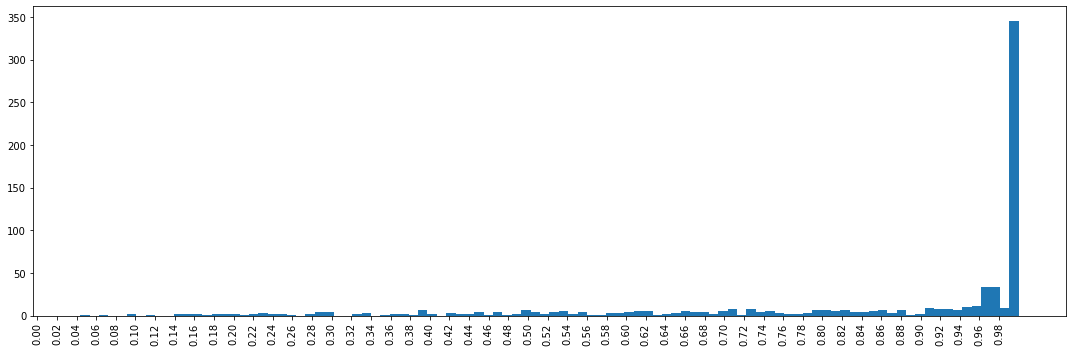

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.hist(answer.iloc[:,1:].max(axis=1), bins=100)
plt.xticks(np.arange(0,1,0.02), rotation=90)
plt.tight_layout()

In [ ]:
for j in range(0, 198):
    train = df_reduc[df_reduc['label'] != -1].copy()
    test = df_reduc[df_reduc['label'] == -1].copy()
    train_1 = train.copy()
    test_1 = test.copy()
    
    train_1.loc[train_1['label'] != j, 'label'] = -10
    train_1.loc[train_1['label'] == j, 'label'] = 1
    train_1.loc[train_1['label'] == -10, 'label'] = 0

    X_train = train_1.iloc[:,2:].copy()
    y_train = train_1['label']

    X_test = test_1.iloc[:,2:].copy()

    feature = df_reduc.columns[2:]

    for i in feature:
        X_train_one = np.array(X_train[i]).reshape(-1,1)
        X_test_one = np.array(X_test[i]).reshape(-1,1)
    
        clf = DecisionTreeClassifier(criterion="entropy", max_depth=2, random_state=1)
        clf = clf.fit(X_train_one,y_train)
    
        y_pred = clf.predict(X_train_one)
        check = len(np.where((y_train == y_pred) == True)[0])
    
        if check == 828:
            y_preds = clf.predict(X_test_one)
            y_preds_1 = [j if value == 1 else -1 for value in y_preds]
            y_preds_all.append(y_preds_1)
            break
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197


In [ ]:
compare2 = (pd.DataFrame(y_preds_all))
compare2.columns = answer['id']

In [ ]:
before = []
for i in range(0, len(compare2.columns)):
    a = list(set(compare2.iloc[:,i]))
    
    if len(a) == 2 and answer.iloc[i,max(a)+1] >= 0.85 and answer.iloc[i,max(a)+1] != 1:
        before.append(answer.iloc[i,max(a)+1])
        answer.iloc[i,max(a)+1] = 1

In [ ]:
sum(before)/len(before)

0.7759833772133394

In [ ]:
len(np.where(answer.iloc[:,1:].max(axis=1) == 1)[0])

310

In [ ]:
answer.to_csv("answer.csv")

In [ ]:
import math